In [ ]:
# %pip install "tensorflow[and-cuda]==2.19.*" -q

In [ ]:
# %pip install --upgrade --no-cache-dir --force-reinstall \
# "numpy==1.26.4" \
# "scipy==1.12.0" \
# "scikit-learn==1.6.*" \
# "umap-learn>=0.5.9.post2" \
# "tensorflow==2.19.*" "tf-keras==2.19.*" "tensorflow-text==2.19.*" \
# "tensorflow-decision-forests==1.12.*" \
# "gensim>=4.3,<4.4" \
# "kagglehub[hf-datasets]"\
# "matplotlib"\
# "nltk"\
# "seaborn"\
# "datasets"\
# "transformers"\
# "torch" "accelerate"\
# -q

In [4]:
import tensorflow as tf, torch

print("Visible GPUs:", tf.config.list_physical_devices("GPU"))

for g in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("Could not activate memory_growth:", e)

x = tf.random.normal((4096, 4096))
y = tf.linalg.matmul(x, x)
print("OK, matmul is ready.")

from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")
torch.set_float32_matmul_precision("medium")

Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
OK, matmul is ready.


I0000 00:00:1759691149.668495  122700 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5518 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:64:00.0, compute capability: 8.9


In [5]:
import numpy, scipy, gensim, sklearn
import tensorflow as tf, tensorflow_text as text
import umap

print("NumPy:", numpy.__version__)
print("SciPy:", scipy.__version__)
print("Gensim:", gensim.__version__)
print("scikit-learn:", sklearn.__version__)
print("TensorFlow:", tf.__version__)
print("tensorflow-text:", text.__version__)
import scipy.linalg as la

print("Has la.triu?", hasattr(la, "triu"))

/home/eubgo/anaconda3/envs/FIFA-WC-sentiment-analysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NumPy: 1.26.4
SciPy: 1.12.0
Gensim: 4.3.3
scikit-learn: 1.6.1
TensorFlow: 2.19.0
tensorflow-text: 2.19.0
Has la.triu? True


In [1]:
# =========================
# 0) IMPORTS + CONFIG
# =========================
import os, re, json, warnings, random, math, sys
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Classic ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
from sklearn.utils.class_weight import compute_class_weight

# Keras / TF
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, regularizers

# DL
import gensim.downloader as api

# HF / Transformers
import torch
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from datasets import Dataset

# KaggleHub
import kagglehub
from kagglehub import KaggleDatasetAdapter

warnings.filterwarnings("ignore")

2025-10-05 15:38:45.009956: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-05 15:38:45.322511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759700325.458694  138278 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759700325.496704  138278 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759700325.756557  138278 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [7]:
# ----- FLAGS  -----
RUN_TFIDF_MODELS = True

RUN_CNN_TWITTER_SE = True
RUN_LSTM_BIATTN = True

RUN_ROBERTA_FEATURES = True
RUN_ROBERTA_FINETUNE = True

RUN_ENSEMBLE_MODELS = True

MAKE_FIGURES = True
SAVE_PER_EXAMPLE_CSV = True

RANDOM_STATE = 42

In [8]:
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [20]:
OUTDIR = Path("artifacts")
OUTDIR.mkdir(exist_ok=True, parents=True)

CACHE_DIR = OUTDIR / "cache_roberta_feats"
CACHE_DIR.mkdir(exist_ok=True, parents=True)

FIGDIR = OUTDIR / "figures"
TABDIR = OUTDIR / "tables"
LOGDIR = OUTDIR / "logs"
for d in (FIGDIR, TABDIR, LOGDIR):
    d.mkdir(exist_ok=True, parents=True)

In [21]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Torch device: {DEVICE}")

[INFO] Torch device: cuda


In [5]:
# =========================
# 1) UTILS
# =========================
def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(r"@\w+", "USR", text)
    text = re.sub(r"(https?://\S+|www\.\S+)", "URL", text)
    text = re.sub(r"#(\w+)", r"hash_\1", text)

    emoticons = r":\)|:-\)|:\(|:-\(|:d|:-d|:p|:-p|;-\)|;\)|xd|xD|:\'\(|<3|♥"
    emojis = r"🤩|😍|😊|😃|😁|😂|🤣|😅|😢|😭|😡|😠|😤|😞|😔|😐|😑|😕|😒|🙃|😉|😎|🥳|🥲|🤔|🙄|😬|🥺|😳|😇|👍|🙏|🔥|💪|👎|💀|🤮|🤯|🤬"

    allowed = rf"[a-z0-9_#!?/\s:)(\-]+"
    parts = re.findall(
        rf"(?:{allowed}|{emoticons}|{emojis})", text, flags=re.IGNORECASE
    )
    text = " ".join(parts)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [2]:
def load_dataset() -> pd.DataFrame:
    try:
        file_path = "fifa_world_cup_2022_tweets.csv"
        hf_dataset = kagglehub.dataset_load(
            KaggleDatasetAdapter.HUGGING_FACE,
            "tirendazacademy/fifa-world-cup-2022-tweets",
            file_path,
        )
        return hf_dataset.to_pandas()
    except Exception as e:
        print("[WARN] No pude descargar dataset:", e)
        if os.path.exists("data/fifa_world_cup_2022_tweets_local.csv"):
            return pd.read_csv("data/fifa_world_cup_2022_tweets_local.csv")
        else:
            raise e

In [24]:
def add_result(
    container: list,
    model_name: str,
    report_dict=None,
    acc=None,
    prec=None,
    rec=None,
    f1=None,
):
    if any(r["Model"] == model_name for r in container):
        return
    if report_dict:
        acc = report_dict.get("accuracy", acc)
        prec = report_dict.get("precision", prec)
        rec = report_dict.get("recall", rec)
        f1 = report_dict.get("f1", f1)
    container.append(
        {
            "Model": model_name,
            "Accuracy": round(acc, 4) if acc is not None else None,
            "Precision": round(prec, 4) if prec is not None else None,
            "Recall": round(rec, 4) if rec is not None else None,
            "F1": round(f1, 4) if f1 is not None else None,
        }
    )

In [25]:
def eval_and_add(container, name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    add_result(container, name, acc=acc, prec=prec, rec=rec, f1=f1)

In [9]:
# =========================
# 2) DATA & SPLIT
# =========================
print("[INFO] Loading dataset...")
df = load_dataset()
print("[INFO] Original shape:", df.shape)

[INFO] Loading dataset...
[INFO] Original shape: (22524, 6)


In [ ]:
df["Sentiment"].value_counts()

Sentiment
positive    8489
neutral     8251
negative    5784
Name: count, dtype: int64

In [6]:
df.drop_duplicates(subset="Tweet", inplace=True)
df = df[df["Tweet"].notnull() & (df["Tweet"].str.strip() != "")]
df["clean_tweet"] = df["Tweet"].apply(preprocess)

In [7]:
df_clf = df[["clean_tweet", "Sentiment"]].copy()
X = df_clf["clean_tweet"]
y = df_clf["Sentiment"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("[INFO] Train/Test:", X_train.shape, X_test.shape)

[INFO] Train/Test: (17888,) (4472,)


In [ ]:
dist_split = pd.DataFrame(
    {
        "split": ["train"] * len(y_train) + ["test"] * len(y_test),
        "label": pd.concat([y_train, y_test]).values,
    }
)
plt.figure(figsize=(6.2, 4.2))
sns.countplot(
    data=dist_split, x="label", hue="split", order=sorted(df["Sentiment"].unique())
)
plt.title("Class Distribution by Split")
out = FIGDIR / "class_distribution_split.png"
plt.savefig(out, dpi=160)
plt.close()
print(f"[FIG] {out.name}")

[FIG] class_distribution_split.png


In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)
print("[INFO] Classes:", list(le.classes_))

[INFO] Classes: ['negative', 'neutral', 'positive']


In [33]:
classes_enc = np.unique(y_train_enc)
weights = compute_class_weight(
    class_weight="balanced", classes=classes_enc, y=y_train_enc
)
class_weight_keras = {int(c): float(w) for c, w in zip(classes_enc, weights)}

if "neutral" in le.classes_:
    neutral_id = int(np.where(le.classes_ == "neutral")[0][0])
    class_weight_keras_tuned = class_weight_keras.copy()
    class_weight_keras_tuned[neutral_id] *= 1.15
else:
    class_weight_keras_tuned = class_weight_keras

In [34]:
# =================================
# 3) TF-IDF + TRADITIONAL ML MODELS
# =================================
results_all = []
vectorizer = None
X_train_tfidf = None
X_test_tfidf = None

In [35]:
if RUN_TFIDF_MODELS:
    print("\n[TF-IDF] Training traditional ML models...")
    vectorizer = TfidfVectorizer(
        max_features=50_000, ngram_range=(1, 3), min_df=2, stop_words="english"
    )
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Logistic Regression
    log_reg = LogisticRegression(
        max_iter=2000, random_state=RANDOM_STATE, class_weight="balanced"
    )
    log_reg.fit(X_train_tfidf, y_train)
    y_pred = log_reg.predict(X_test_tfidf)
    y_proba_lr = log_reg.predict_proba(X_test_tfidf)
    eval_and_add(results_all, "Logistic Regression (TF-IDF)", y_test, y_pred)
    print(
        f"[RESULT] Logistic Regression (TF-IDF): {log_reg.score(X_test_tfidf, y_test)}"
    )

    # Linear SVC
    svm_clf = LinearSVC(random_state=RANDOM_STATE)
    svm_clf.fit(X_train_tfidf, y_train)
    y_pred = svm_clf.predict(X_test_tfidf)
    eval_and_add(results_all, "LinearSVC (TF-IDF)", y_test, y_pred)
    print(f"[RESULT] LinearSVC (TF-IDF): {svm_clf.score(X_test_tfidf, y_test)}")

    # Random Forest
    rf_clf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
    )
    rf_clf.fit(X_train_tfidf, y_train)
    y_pred = rf_clf.predict(X_test_tfidf)
    y_proba_rf = rf_clf.predict_proba(X_test_tfidf)
    eval_and_add(results_all, "RandomForest (TF-IDF)", y_test, y_pred)
    print(f"[RESULT] RandomForest (TF-IDF): {rf_clf.score(X_test_tfidf, y_test)}")


[TF-IDF] Training traditional ML models...
[RESULT] Logistic Regression (TF-IDF): 0.7068425760286225
[RESULT] LinearSVC (TF-IDF): 0.6985688729874776
[RESULT] RandomForest (TF-IDF): 0.6773255813953488


In [ ]:
# ========================================================
# 4) DL – Tokenizer + Twitter embeddings + CNN SE+Attn
# ========================================================
tok = None
Xtr_pad = None
Xte_pad = None

In [ ]:
def build_embedding_matrix(kv, tokenizer, max_vocab):
    dim = kv.vector_size
    mat = np.random.normal(0, 0.6, size=(max_vocab, dim)).astype("float32")
    mat[0] = 0.0

    known = [
        kv[w]
        for w, idx in tokenizer.word_index.items()
        if idx < max_vocab and (w in kv)
    ]
    mean_vec = np.mean(known, axis=0) if len(known) else np.zeros(dim, dtype="float32")

    for w, idx in tokenizer.word_index.items():
        if idx >= max_vocab:
            continue
        if w in kv:
            mat[idx] = kv[w]
    oov_idx = tokenizer.word_index.get("<OOV>")
    if oov_idx is not None and oov_idx < max_vocab:
        mat[oov_idx] = mean_vec
    return mat

In [38]:
def se_block(x, r=8):
    ch = x.shape[-1]
    s = layers.GlobalAveragePooling1D()(x)
    s = layers.Dense(ch // r, activation="relu")(s)
    s = layers.Dense(ch, activation="sigmoid")(s)
    s = layers.Reshape((1, ch))(s)
    return layers.Multiply()([x, s])

In [39]:
def attention_pool(h):
    maxp = layers.GlobalMaxPooling1D()(h)
    avgp = layers.GlobalAveragePooling1D()(h)
    a = layers.Dense(64, activation="tanh")(h)
    a = layers.Dense(1, use_bias=False)(a)
    a = layers.Lambda(lambda x: tf.nn.softmax(x, axis=1))(a)
    att = layers.Multiply()([h, a])
    att = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(att)
    return layers.Concatenate()([maxp, avgp, att])

In [40]:
def make_lstm_biattn(
    vocab_size,
    emb_matrix,
    max_len,
    num_classes,
    trainable=False,
    lstm1_units=96,
    lstm2_units=64,
    dropout_rate=0.4,
    use_recurrent_dropout=True,
):
    from tensorflow.keras import layers, models, regularizers
    import tensorflow as tf

    def attention_pool(h):
        maxp = layers.GlobalMaxPooling1D()(h)
        avgp = layers.GlobalAveragePooling1D()(h)
        a = layers.Dense(64, activation="tanh")(h)
        a = layers.Dense(1, use_bias=False)(a)
        a = layers.Lambda(lambda x: tf.nn.softmax(x, axis=1))(a)
        att = layers.Multiply()([h, a])
        att = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(att)
        return layers.Concatenate()([maxp, avgp, att])

    emb_dim = emb_matrix.shape[1]
    inp = layers.Input(shape=(max_len,), name="input_ids")
    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=emb_dim,
        weights=[emb_matrix],
        trainable=trainable,
        mask_zero=True,
        name="embedding",
    )(inp)

    x = layers.SpatialDropout1D(0.2)(x)

    rd1 = 0.2 if use_recurrent_dropout else 0.0
    rd2 = 0.2 if use_recurrent_dropout else 0.0

    x = layers.Bidirectional(
        layers.LSTM(
            lstm1_units, return_sequences=True, dropout=0.2, recurrent_dropout=rd1
        )
    )(x)
    x = layers.Bidirectional(
        layers.LSTM(
            lstm2_units, return_sequences=True, dropout=0.2, recurrent_dropout=rd2
        )
    )(x)

    h = attention_pool(x)
    h = layers.Dropout(dropout_rate)(h)
    h = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(
        h
    )
    h = layers.Dropout(dropout_rate)(h)

    out = layers.Dense(num_classes, activation="softmax")(h)

    model = models.Model(inp, out, name="BiLSTM_Attn")
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=["accuracy"],
    )
    return model

In [113]:
from gensim.models import KeyedVectors

if RUN_LSTM_BIATTN:
    cb_lstm_stage12 = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1
        ),
    ]
    cb_lstm_stage3 = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        ),
    ]

    print("\n[BiLSTM+Attn] Preparing embeddings + model...")

    MAX_VOCAB = 50_000
    MAX_LEN = 180

    if tok is None or Xtr_pad is None or Xte_pad is None:
        print(
            "[BiLSTM+Attn] Didn't found tokenizer/padding. Creating them..."
        )
        X_train_dl = X_train.str.replace(r"\bhash_", "", regex=True)
        X_test_dl = X_test.str.replace(r"\bhash_", "", regex=True)

        tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
        tok.fit_on_texts(X_train_dl)
        Xtr_seq = tok.texts_to_sequences(X_train_dl)
        Xte_seq = tok.texts_to_sequences(X_test_dl)
        Xtr_pad = pad_sequences(
            Xtr_seq, maxlen=MAX_LEN, padding="post", truncating="post"
        )
        Xte_pad = pad_sequences(
            Xte_seq, maxlen=MAX_LEN, padding="post", truncating="post"
        )
    VOCAB_SIZE = min(MAX_VOCAB, len(tok.word_index) + 1)

    # --- GloVe-Twitter Embeddings ---
    if "emb_twitter" not in locals():
        try:
            glove_tw = api.load("glove-twitter-200")
        except Exception as e:
            print("[WARN] Could not download GloVe:", e)
            if os.path.exists("vectors/glove-twitter-200.kv"):
                glove_tw = KeyedVectors.load("vectors/glove-twitter-200.kv")
            else:
                raise e
        emb_twitter = build_embedding_matrix(glove_tw, tok, MAX_VOCAB)
        emb_twitter = emb_twitter[:VOCAB_SIZE, :]

    emb_lstm = emb_twitter.copy()
    if emb_lstm.shape[0] > 0 and np.any(emb_lstm[0] != 0.0):
        emb_lstm[0] = 0.0

    # --- LSTM Model ---
    lstm_glove = make_lstm_biattn(
        vocab_size=VOCAB_SIZE,
        emb_matrix=emb_lstm,
        max_len=MAX_LEN,
        num_classes=num_classes,
        trainable=False,
        lstm1_units=96,
        lstm2_units=64,
        dropout_rate=0.4,
        use_recurrent_dropout=False,
    )

    # ===== Stage 1 =====
    history_lstm_1 = lstm_glove.fit(
        Xtr_pad,
        y_train_enc,
        validation_split=0.1,
        epochs=8,
        batch_size=64,
        callbacks=cb_lstm_stage12,
        verbose=1,
    )

    # ===== Stage 2: unfreeze embedding + class_weight =====
    lstm_glove.get_layer("embedding").trainable = True
    lstm_glove.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1.0),
        metrics=["accuracy"],
    )
    history_lstm_2 = lstm_glove.fit(
        Xtr_pad,
        y_train_enc,
        validation_split=0.1,
        epochs=8,
        batch_size=64,
        class_weight=class_weight_keras,
        callbacks=cb_lstm_stage12,
        verbose=1,
    )

    # ===== Stage 3: CosineDecayRestarts  =====
    batch_size_stage3 = 64
    steps_per_epoch = int(
        np.ceil(len(Xtr_pad) * 0.9 / batch_size_stage3)
    )

    sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=5e-5,
        first_decay_steps=steps_per_epoch,
        t_mul=2.0,
        m_mul=0.9,
        alpha=1e-6,
    )
    lstm_glove.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=sched, clipnorm=1.0),
        metrics=["accuracy"],
    )
    history_lstm_3 = lstm_glove.fit(
        Xtr_pad,
        y_train_enc,
        validation_split=0.1,
        epochs=6,
        batch_size=batch_size_stage3,
        class_weight=class_weight_keras_tuned,
        callbacks=cb_lstm_stage3,
        verbose=1,
    )

    # --- Evaluation ---
    y_prob_lstm = lstm_glove.predict(Xte_pad, verbose=0)
    y_pred_lstm = y_prob_lstm.argmax(axis=1)
    y_proba_lstm = y_prob_lstm

    add_result(
        results_all,
        "BiLSTM+Attention (GloVe-Twitter)",
        acc=accuracy_score(y_test_enc, y_pred_lstm),
        prec=precision_recall_fscore_support(y_test_enc, y_pred_lstm, average="macro")[
            0
        ],
        rec=precision_recall_fscore_support(y_test_enc, y_pred_lstm, average="macro")[
            1
        ],
        f1=precision_recall_fscore_support(y_test_enc, y_pred_lstm, average="macro")[2],
    )
    print(
        f"[RESULT] BiLSTM+Attention (GloVe-Twitter): {accuracy_score(y_test_enc, y_pred_lstm):.4f}"
    )


[BiLSTM+Attn] Preparing embeddings + model...
Epoch 1/8
252/252 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.5810 - loss: 0.8919 - val_accuracy: 0.6875 - val_loss: 0.7173 - learning_rate: 0.0010
Epoch 2/8
252/252 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.6851 - loss: 0.7198 - val_accuracy: 0.7300 - val_loss: 0.6423 - learning_rate: 0.0010
Epoch 3/8
252/252 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.7081 - loss: 0.6699 - val_accuracy: 0.7485 - val_loss: 0.6154 - learning_rate: 0.0010
Epoch 4/8
252/252 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7307 - loss: 0.6324 - val_accuracy: 0.7513 - val_loss: 0.6050 - learning_rate: 0.0010
Epoch 5/8
252/252 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.7444 - loss: 0.6036 - val_accuracy: 0.7602 - val_loss: 0.5834 - learning_rate: 0.0010
Epoch 6/8
252/252 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7565 - loss: 0.5759 - val_accuracy: 0.7697 - val_loss: 0.5739 - learning_rate: 0.0010
Epoch 7/8
252/252 ━━━━━━━━━━━━━━━━━

In [42]:
def make_textcnn(vocab_size, emb_matrix, max_len, num_classes, trainable=False):
    emb_dim = emb_matrix.shape[1]
    inp = layers.Input(shape=(max_len,), name="input_ids")
    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=emb_dim,
        weights=[emb_matrix],
        trainable=trainable,
        name="embedding",
    )(inp)
    x = layers.SpatialDropout1D(0.2, name="spatial_dropout")(x)

    branches = []
    for k in (2, 3, 4, 5, 7):
        b = layers.Conv1D(128, k, padding="same", activation=None, name=f"conv_{k}")(x)
        b = layers.BatchNormalization(name=f"bn_{k}")(b)
        b = layers.Activation("relu", name=f"relu_{k}")(b)
        b = se_block(b)
        branches.append(attention_pool(b))

    h = layers.Concatenate(name="concat_branches")(branches)
    h = layers.Dropout(0.4, name="dropout_head")(h)
    h = layers.Dense(
        192,
        activation="relu",
        kernel_regularizer=regularizers.l2(1e-4),
        name="dense_192",
    )(h)
    h = layers.Dropout(0.4, name="dropout_192")(h)
    out = layers.Dense(num_classes, activation="softmax", name="classifier")(h)

    model = models.Model(inp, out, name="TextCNN_TwitterSE_Attn")
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=["accuracy"],
    )
    return model

In [ ]:
from gensim.models import KeyedVectors

try:
    glove_tw = api.load("glove-twitter-200")
except Exception as e:
    print("[WARN] Could not download GloVe:", e)
    if os.path.exists("vectors/glove-twitter-200.kv"):
        glove_tw = KeyedVectors.load("vectors/glove-twitter-200.kv")
    else:
        raise e

if RUN_CNN_TWITTER_SE:
    print("\n[CNN-SE] Tokenizing + Twitter embeddings + training...")

    X_train_dl = X_train.str.replace(r"\bhash_", "", regex=True)
    X_test_dl = X_test.str.replace(r"\bhash_", "", regex=True)

    MAX_VOCAB = 50_000
    MAX_LEN = 180

    tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
    tok.fit_on_texts(X_train_dl)

    Xtr_seq = tok.texts_to_sequences(X_train_dl)
    Xte_seq = tok.texts_to_sequences(X_test_dl)
    Xtr_pad = pad_sequences(Xtr_seq, maxlen=MAX_LEN, padding="post", truncating="post")
    Xte_pad = pad_sequences(Xte_seq, maxlen=MAX_LEN, padding="post", truncating="post")

    VOCAB_SIZE = min(MAX_VOCAB, len(tok.word_index) + 1)

    # --- Glove-Twitter Embeddings ---
    emb_twitter = build_embedding_matrix(glove_tw, tok, MAX_VOCAB)
    emb_twitter = emb_twitter[:VOCAB_SIZE, :]

    if emb_twitter.shape[0] > 0:
        emb_twitter[0] = 0.0

    # --- Model ---
    cnn_twitter = make_textcnn(
        VOCAB_SIZE, emb_twitter, MAX_LEN, num_classes, trainable=False
    )

    cb_cnn_stage12 = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1
        ),
    ]
    cb_cnn_stage3 = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        )
    ]

    # --- Stage 1 ---
    history_stage1 = cnn_twitter.fit(
        Xtr_pad,
        y_train_enc,
        validation_split=0.1,
        epochs=12,
        batch_size=128,
        callbacks=cb_cnn_stage12,
        verbose=1,
    )

    # --- Stage 2 (unfreeze + class_weight) ---
    cnn_twitter.get_layer("embedding").trainable = True
    cnn_twitter.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1.0),
        metrics=["accuracy"],
    )
    history_stage2 = cnn_twitter.fit(
        Xtr_pad,
        y_train_enc,
        validation_split=0.1,
        epochs=10,
        batch_size=128,
        callbacks=cb_cnn_stage12,
        class_weight=class_weight_keras,
        verbose=1,
    )

    # --- Stage 3 (fine-tuning with CosineDecayRestarts) ---
    batch_size_stage3 = 64
    steps_per_epoch = int(np.ceil(len(Xtr_pad) * 0.9 / batch_size_stage3))

    sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=5e-5,
        first_decay_steps=steps_per_epoch,
        t_mul=2.0,
        m_mul=0.9,
        alpha=1e-6,
    )
    cnn_twitter.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=sched, clipnorm=1.0),
        metrics=["accuracy"],
    )
    history_stage3 = cnn_twitter.fit(
        Xtr_pad,
        y_train_enc,
        validation_split=0.1,
        epochs=8,
        batch_size=batch_size_stage3,
        callbacks=cb_cnn_stage3,
        class_weight=class_weight_keras_tuned,
        verbose=1,
    )

    # --- Final Evaluation ---
    y_prob_cnn = cnn_twitter.predict(Xte_pad, verbose=0)
    y_pred_cnn = y_prob_cnn.argmax(axis=1)
    y_proba_cnn = y_prob_cnn
    eval_and_add(results_all, "CNN (Twitter SE+Attn)", y_test_enc, y_pred_cnn)
    print(
        f"[RESULT] CNN (Twitter SE+Attn): {accuracy_score(y_test_enc, y_pred_cnn):.4f}"
    )


[CNN-SE] Tokenizing + Twitter embeddings + training...
Epoch 1/12


I0000 00:00:1759691663.421268  122908 service.cc:152] XLA service 0x7ff06c8805d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759691663.421318  122908 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-10-05 13:14:23.546495: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-05 13:14:26.972273: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 25.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-05 13:14:27.063010: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 25.23GiB with freed_by_count=0. The call

  2/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.2832 - loss: 3.5559  

I0000 00:00:1759691673.493167  122908 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3578 - loss: 2.6763

2025-10-05 13:14:37.540679: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 22.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3597 - loss: 2.6304

2025-10-05 13:14:44.670276: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_879', 32 bytes spill stores, 32 bytes spill loads

2025-10-05 13:14:46.637005: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_245', 4 bytes spill stores, 4 bytes spill loads

2025-10-05 13:14:47.088130: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 60 bytes spill stores, 60 bytes spill loads

2025-10-05 13:14:47.524890: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_879', 44 bytes spill stores, 44 bytes spill loads

2025-10-05 13:14:48.056391: W external/local_xla/x

126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.3997 - loss: 1.6986 - val_accuracy: 0.5774 - val_loss: 1.0619 - learning_rate: 0.0010
Epoch 2/12
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5671 - loss: 0.9205 - val_accuracy: 0.6663 - val_loss: 0.8613 - learning_rate: 0.0010
Epoch 3/12
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6497 - loss: 0.7869 - val_accuracy: 0.7183 - val_loss: 0.6973 - learning_rate: 0.0010
Epoch 4/12
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6927 - loss: 0.7182 - val_accuracy: 0.7323 - val_loss: 0.6361 - learning_rate: 0.0010
Epoch 5/12
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7229 - loss: 0.6628 - val_accuracy: 0.7339 - val_loss: 0.6157 - learning_rate: 0.0010
Epoch 6/12
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7443 - loss: 0.6158 - val_accuracy: 0.7490 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 7/12
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7555 - loss: 0.5908 - val_accu

2025-10-05 13:16:03.486075: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_245', 4 bytes spill stores, 4 bytes spill loads

2025-10-05 13:16:04.210037: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 60 bytes spill stores, 60 bytes spill loads



252/252 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.8099 - loss: 0.4869 - val_accuracy: 0.7529 - val_loss: 0.5639
Epoch 2/8
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8075 - loss: 0.4892 - val_accuracy: 0.7507 - val_loss: 0.5586
Epoch 3/8
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8145 - loss: 0.4788 - val_accuracy: 0.7513 - val_loss: 0.5611
Epoch 4/8
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8160 - loss: 0.4707 - val_accuracy: 0.7541 - val_loss: 0.5622
Epoch 5/8
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8209 - loss: 0.4668 - val_accuracy: 0.7518 - val_loss: 0.5638


2025-10-05 13:16:16.780612: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 60 bytes spill stores, 60 bytes spill loads

2025-10-05 13:16:17.469657: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_764', 180 bytes spill stores, 180 bytes spill loads

2025-10-05 13:16:19.977815: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 60 bytes spill stores, 60 bytes spill loads

2025-10-05 13:16:21.005005: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_839', 212 bytes spill stores, 212 bytes spill loads



[RESULT] CNN (Twitter SE+Attn): 0.7592


In [ ]:
# ==============================================
# 5) TRANSFORMER – feature extractor + heads
# ==============================================
Xtr_emb, Xte_emb = None, None
y_pred_roberta_ft = None
eval_metrics_ft = None


def encode_texts(
    texts, tokenizer, model, device, batch_size=64, max_len=96, pooling="mean"
):
    embs = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i : i + batch_size]
            tok = tokenizer(
                list(batch),
                padding=True,
                truncation=True,
                max_length=max_len,
                return_tensors="pt",
            ).to(device)
            out = model(**tok)
            if pooling == "cls":
                vec = out.last_hidden_state[:, 0, :]
            else:
                mask = tok.attention_mask.unsqueeze(-1)
                summed = (out.last_hidden_state * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1)
                vec = summed / counts
            embs.append(vec.detach().cpu().numpy().astype("float32"))
    return np.vstack(embs)

In [45]:
if RUN_ROBERTA_FEATURES or RUN_ROBERTA_FINETUNE:
    MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    tok_hf = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

In [46]:
if RUN_ROBERTA_FEATURES:
    print("\n[RoBERTa FE] Extracting embeddings + training traditional heads...")
    backbone = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)

    tr_path = CACHE_DIR / "Xtr_roberta_mean96.npy"
    te_path = CACHE_DIR / "Xte_roberta_mean96.npy"
    if tr_path.exists() and te_path.exists():
        Xtr_emb = np.load(tr_path)
        Xte_emb = np.load(te_path)
    else:
        Xtr_emb = encode_texts(
            X_train.tolist(),
            tok_hf,
            backbone,
            DEVICE,
            max_len=96,
            batch_size=64,
            pooling="mean",
        )
        Xte_emb = encode_texts(
            X_test.tolist(),
            tok_hf,
            backbone,
            DEVICE,
            max_len=96,
            batch_size=64,
            pooling="mean",
        )
        np.save(tr_path, Xtr_emb)
        np.save(te_path, Xte_emb)

    # Heads
    lr_head = LogisticRegression(
        max_iter=2000, C=1.0, n_jobs=-1, random_state=RANDOM_STATE
    )
    svm_head = LinearSVC(C=1.0, random_state=RANDOM_STATE)

    lr_head.fit(Xtr_emb, y_train)
    y_pred = lr_head.predict(Xte_emb)
    y_proba_roberta_lr = lr_head.predict_proba(Xte_emb)
    eval_and_add(results_all, "RoBERTa feature extractor (LogReg head)", y_test, y_pred)
    print(
        f"[RESULT] RoBERTa feature extractor (LogReg head): {accuracy_score(y_test, y_pred)}"
    )

    svm_head.fit(Xtr_emb, y_train)
    y_pred = svm_head.predict(Xte_emb)
    eval_and_add(
        results_all, "RoBERTa feature extractor (LinearSVC head)", y_test, y_pred
    )
    print(
        f"[RESULT] RoBERTa feature extractor (LinearSVC head): {accuracy_score(y_test, y_pred)}"
    )


[RoBERTa FE] Extracting embeddings + training traditional heads...
[RESULT] RoBERTa feature extractor (LogReg head): 0.8868515205724508
[RESULT] RoBERTa feature extractor (LinearSVC head): 0.8841681574239714


In [ ]:
# =================================
# 6) TRANSFORMER – fine-tuning
# =================================
if RUN_ROBERTA_FINETUNE:
    print("\n[RoBERTa FT] Fine-tuning twitter-roberta-base-sentiment-latest...")

    label2id = {lbl: i for i, lbl in enumerate(sorted(np.unique(y_train)))}
    id2label = {i: lbl for lbl, i in label2id.items()}

    def map_labels(y_list):
        return [label2id[l] for l in y_list]

    train_ds = Dataset.from_dict({"text": X_train.tolist(), "label": map_labels(y_train.tolist())})
    test_ds  = Dataset.from_dict({"text": X_test.tolist(),  "label": map_labels(y_test.tolist())})

    def tokenize_fn(batch):
        return tok_hf(batch["text"], truncation=True, padding=True, max_length=128)

    train_ds = train_ds.map(tokenize_fn, batched=True)
    test_ds  = test_ds.map(tokenize_fn, batched=True)

    model_ft = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=len(label2id), id2label=id2label, label2id=label2id
    ).to(DEVICE)

    args = TrainingArguments(
        output_dir=str(OUTDIR / "roberta_finetuned"),
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_steps=50,
        save_total_limit=1,
        report_to="none"
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=1)
        acc = accuracy_score(labels, preds)
        prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
        return {"accuracy": acc, "f1": f1, "precision": prec, "recall": rec}

    trainer = Trainer(
        model=model_ft, args=args,
        train_dataset=train_ds, eval_dataset=test_ds,
        tokenizer=tok_hf, compute_metrics=compute_metrics
    )

    trainer.train()
    eval_metrics_ft = trainer.evaluate()

    # Predictions of the fine-tuned model
    pred_logits = trainer.predict(test_ds).predictions
    import numpy as _np
    y_proba_roberta_ft = _np.exp(pred_logits - _np.max(pred_logits, axis=1, keepdims=True))
    y_proba_roberta_ft = y_proba_roberta_ft / _np.sum(y_proba_roberta_ft, axis=1, keepdims=True)
    pred_ids = pred_logits.argmax(axis=1)
    y_pred_roberta_ft = [id2label[i] for i in pred_ids]
    eval_and_add(results_all, "RoBERTa fine-tuned (twitter-roberta-base-sentiment-latest)", y_test, y_pred_roberta_ft)
    print(f"[RESULT] RoBERTa fine-tuned (twitter-roberta-base-sentiment-latest): {accuracy_score(y_test, y_pred_roberta_ft)}")



[RoBERTa FT] Fine-tuning de twitter-roberta-base-sentiment-latest...


Map:   0%|          | 0/17888 [00:00<?, ? examples/s]

Map: 100%|██████████| 4472/4472 [00:00<00:00, 22035.17 examples/s]
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss
50,0.422000
100,0.447300
150,0.358300
200,0.396600
250,0.394700
300,0.341100
350,0.342700
400,0.364900
450,0.403900
500,0.372100


[RESULT] RoBERTa fine-tuned (twitter-roberta-base-sentiment-latest): 0.8978085867620751


In [ ]:
import numpy as np
from collections import Counter
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
)

if RUN_ENSEMBLE_MODELS:

    def to_labels(y_pred):
        if y_pred is None or len(y_pred) == 0:
            return None
        if isinstance(y_pred[0], str):
            return np.array(y_pred, dtype=object)
        return le.inverse_transform(np.array(y_pred)).astype(object)

    y_pred_roberta_ft_text = to_labels(y_pred_roberta_ft)
    y_pred_lstm_text = to_labels(y_pred_lstm)
    y_pred_cnn_text = to_labels(y_pred_cnn)

    def safe_zip(*arrays):
        maxlen = max(len(a) for a in arrays if a is not None)
        filled = []
        for a in arrays:
            if a is None:
                filled.append([None] * maxlen)
            else:
                filled.append(a)
        return zip(*filled)

    y_pred_roberta_ft = to_labels(y_pred_roberta_ft)
    y_pred_lstm = to_labels(y_pred_lstm)
    y_pred_cnn = to_labels(y_pred_cnn)

    y_true = to_labels(y_test_enc)

    # ======================
    # 1) WEIGHTED VOTING
    # ======================
    weights = {"roberta": 0.90, "lstm": 0.76, "cnn": 0.75}

    def weighted_vote(roberta, lstm, cnn):
        votes = Counter()
        if roberta is not None:
            votes[roberta] += weights["roberta"]
        if lstm is not None:
            votes[lstm] += weights["lstm"]
        if cnn is not None:
            votes[cnn] += weights["cnn"]

        if not votes:
            return None

        top = votes.most_common(2)
        # No tie
        if len(top) == 1 or top[0][1] != top[1][1]:
            return top[0][0]

        # Tie: priorize RoBERTa if tied
        tied_weight = top[0][1]
        tied_labels = {lbl for lbl, w in top if w == tied_weight}
        if roberta in tied_labels:
            return roberta
        return top[0][0]

    y_pred_ens_weighted = np.array(
        [
            weighted_vote(r, l, c)
            for r, l, c in safe_zip(
                y_pred_roberta_ft_text, y_pred_lstm_text, y_pred_cnn_text
            )
        ],
        dtype=object,
    )

    mask_w = y_pred_ens_weighted != None

    acc_w = accuracy_score(y_true[mask_w], y_pred_ens_weighted[mask_w])
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        y_true[mask_w], y_pred_ens_weighted[mask_w], average="macro"
    )

    print("\n=== Ensemble (Weighted Voting) ===")
    print(f"Accuracy:  {acc_w:.4f}")
    print(f"Precision: {prec_w:.4f}")
    print(f"Recall:    {rec_w:.4f}")
    print(f"F1:        {f1_w:.4f}")
    print(classification_report(y_true[mask_w], y_pred_ens_weighted[mask_w]))

    add_result(
        results_all,
        "Ensemble (Weighted Voting)",
        acc=acc_w,
        prec=prec_w,
        rec=rec_w,
        f1=f1_w,
    )

    # ======================
    # 2) MAJORITY VOTING
    # ======================
    def majority_vote(roberta, lstm, cnn):
        votes = Counter()
        if roberta is not None:
            votes[roberta] += 1.0
        if lstm is not None:
            votes[lstm] += 1.0
        if cnn is not None:
            votes[cnn] += 1.0

        if not votes:
            return None

        top = votes.most_common(2)
        # Clear majority
        if len(top) == 1 or top[0][1] != top[1][1]:
            return top[0][0]

        # Tie: priorize RoBERTa if tied
        tied_count = top[0][1]
        tied_labels = {lbl for lbl, c in top if c == tied_count}
        if roberta in tied_labels:
            return roberta
        return top[0][0]

    y_pred_ens_majority = np.array(
        [
            majority_vote(r, l, c)
            for r, l, c in safe_zip(
                y_pred_roberta_ft_text, y_pred_lstm_text, y_pred_cnn_text
            )
        ],
        dtype=object,
    )

    mask_m = y_pred_ens_majority != None

    acc_m = accuracy_score(y_true[mask_m], y_pred_ens_majority[mask_m])
    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
        y_true[mask_m], y_pred_ens_majority[mask_m], average="macro"
    )

    print("\n=== Ensemble (Majority Voting) ===")
    print(f"Accuracy:  {acc_m:.4f}")
    print(f"Precision: {prec_m:.4f}")
    print(f"Recall:    {rec_m:.4f}")
    print(f"F1:        {f1_m:.4f}")
    print(classification_report(y_true[mask_m], y_pred_ens_majority[mask_m]))

    add_result(
        results_all,
        "Ensemble (Majority Voting)",
        acc=acc_m,
        prec=prec_m,
        rec=rec_m,
        f1=f1_m,
    )

    # Select the best ensemble
    if f1_w >= f1_m:
        y_pred_ens = y_pred_ens_weighted
        ens_name = "Ensemble (Weighted Voting)"
        best_scores = (acc_w, prec_w, rec_w, f1_w)
    else:
        y_pred_ens = y_pred_ens_majority
        ens_name = "Ensemble (Majority Voting)"
        best_scores = (acc_m, prec_m, rec_m, f1_m)

    print(
        f"\n>>> Best ensemble: {ens_name} | Acc={best_scores[0]:.4f} Prec={best_scores[1]:.4f} Rec={best_scores[2]:.4f} F1={best_scores[3]:.4f}"
    )


=== Ensemble (Weighted Voting) ===
Accuracy:  0.8090
Precision: 0.8063
Recall:    0.8152
F1:        0.8090
              precision    recall  f1-score   support

    negative       0.76      0.87      0.81      1149
     neutral       0.79      0.76      0.78      1638
    positive       0.87      0.81      0.84      1685

    accuracy                           0.81      4472
   macro avg       0.81      0.82      0.81      4472
weighted avg       0.81      0.81      0.81      4472


=== Ensemble (Majority Voting) ===
Accuracy:  0.8090
Precision: 0.8063
Recall:    0.8152
F1:        0.8090
              precision    recall  f1-score   support

    negative       0.76      0.87      0.81      1149
     neutral       0.79      0.76      0.78      1638
    positive       0.87      0.81      0.84      1685

    accuracy                           0.81      4472
   macro avg       0.81      0.82      0.81      4472
weighted avg       0.81      0.81      0.81      4472


>>> Best ensamble: En

In [ ]:
# ================================
# 7) RESUMES, TABLES AND GRAPHS
# ================================
print("\n" + "=" * 60)
print(f"✅ Models added: {len(results_all)}")
print("=" * 60)

df_results_all = pd.DataFrame(results_all).sort_values("F1", ascending=False)
print(df_results_all.to_string(index=False))
# Save to csv
df_results_all.to_csv("model_results.csv", index=False)
# Save to json
with open("model_results.json", "w") as f:
    json.dump(results_all, f)


✅ Models added: 10
                                                     Model  Accuracy  Precision  Recall     F1
RoBERTa fine-tuned (twitter-roberta-base-sentiment-latest)    0.8978     0.8975  0.9011 0.8990
                   RoBERTa feature extractor (LogReg head)    0.8869     0.8892  0.8890 0.8891
                RoBERTa feature extractor (LinearSVC head)    0.8842     0.8867  0.8861 0.8863
                                Ensemble (Weighted Voting)    0.8090     0.8063  0.8152 0.8090
                                Ensemble (Majority Voting)    0.8090     0.8063  0.8152 0.8090
                          BiLSTM+Attention (GloVe-Twitter)    0.7641     0.7621  0.7693 0.7642
                                     CNN (Twitter SE+Attn)    0.7592     0.7571  0.7669 0.7593
                              Logistic Regression (TF-IDF)    0.7068     0.7050  0.7119 0.7078
                                        LinearSVC (TF-IDF)    0.6986     0.7001  0.6990 0.6994
                              

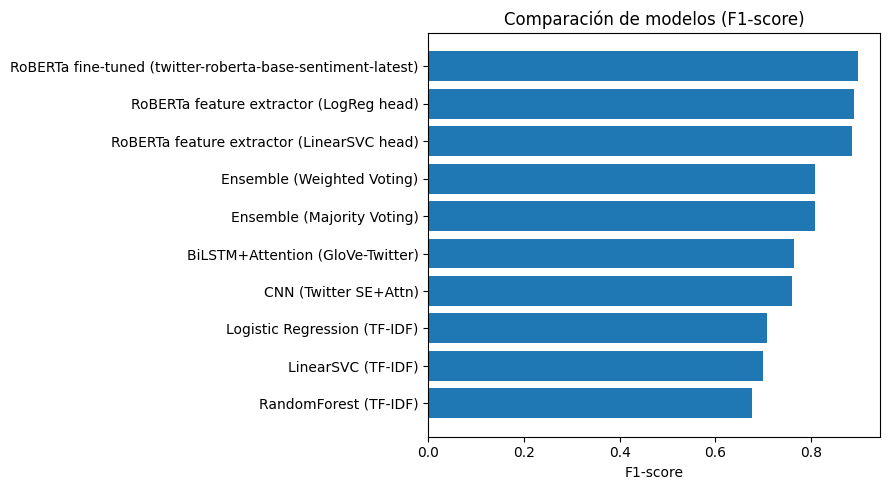

In [51]:
# Comparison graph
if MAKE_FIGURES and not df_results_all.empty:
    plt.figure(figsize=(9, 5))
    plt.barh(df_results_all["Model"], df_results_all["F1"])
    plt.gca().invert_yaxis()
    plt.title("Comparación de modelos (F1-score)")
    plt.xlabel("F1-score")
    plt.tight_layout()
    plt.savefig("model_f1_comparison.png", dpi=160)
    plt.show()

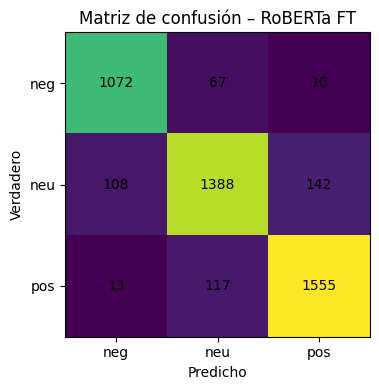

In [52]:
# Confusion matrix of the best available model
best_name = None
y_pred_best = None
if y_pred_roberta_ft is not None:
    best_name = "RoBERTa FT"
    y_pred_best = y_pred_roberta_ft
elif RUN_CNN_TWITTER_SE and Xte_pad is not None:
    best_name = "CNN (Twitter SE+Attn)"
    y_pred_best = le.inverse_transform(y_pred_cnn) if "y_pred_cnn" in locals() else None
elif RUN_TFIDF_MODELS and "log_reg" in locals():
    best_name = "Logistic Regression (TF-IDF)"
    y_pred_best = log_reg.predict(X_test_tfidf) if X_test_tfidf is not None else None

if MAKE_FIGURES and y_pred_best is not None:
    labels_order = ["negative", "neutral", "positive"]
    cm = confusion_matrix(y_test, y_pred_best, labels=labels_order)
    plt.figure(figsize=(4.5, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix – {best_name}")
    plt.xticks(range(len(labels_order)), ["neg", "neu", "pos"])
    plt.yticks(range(len(labels_order)), ["neg", "neu", "pos"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig("confusion_matrix_best.png", dpi=160)
    plt.show()

In [53]:
# =========================
# 8) PER-EXAMPLE PREDICTIONS
# =========================
def safe_predict(model, X, name):
    try:
        return model.predict(X)
    except Exception as e:
        print(f"[WARN] Could not predict with {name}: {e}")
        return pd.Series([None] * len(X))

In [54]:
df_all_preds = pd.DataFrame(
    {"text": X_test.reset_index(drop=True), "true": y_test.reset_index(drop=True)}
)

In [77]:
if RUN_TFIDF_MODELS and X_test_tfidf is not None:
    if "log_reg" in locals():
        df_all_preds["pred_lr_tfidf"] = pd.Series(
            safe_predict(log_reg, X_test_tfidf, "LR TF-IDF")
        )
    if "svm_clf" in locals():
        df_all_preds["pred_svm_tfidf"] = pd.Series(
            safe_predict(svm_clf, X_test_tfidf, "LinearSVC TF-IDF")
        )
    if "rf_clf" in locals():
        df_all_preds["pred_rf_tfidf"] = pd.Series(
            safe_predict(rf_clf, X_test_tfidf, "RF TF-IDF")
        )

In [ ]:
def ensure_text_labels(arr, le):
    if arr is None:
        return None
    arr = np.asarray(arr)
    if arr.size == 0:
        return arr
    if arr.dtype == object or isinstance(arr[0], str):
        return arr.astype(object)
    return le.inverse_transform(arr.astype(int)).astype(object)

if RUN_CNN_TWITTER_SE and Xte_pad is not None and "y_pred_cnn" in locals():
    df_all_preds["pred_cnn_twitter_se"] = pd.Series(
        ensure_text_labels(y_pred_cnn, le)
    ).reset_index(drop=True)

if RUN_LSTM_BIATTN and Xte_pad is not None and "y_pred_lstm" in locals():
    df_all_preds["pred_lstm_biattn"] = pd.Series(
        ensure_text_labels(y_pred_lstm, le)
    ).reset_index(drop=True)

In [79]:
if RUN_ROBERTA_FEATURES and Xte_emb is not None:
    if "lr_head" in locals():
        df_all_preds["pred_roberta_lr"] = pd.Series(
            safe_predict(lr_head, Xte_emb, "RoBERTa + LR head")
        )
    if "svm_head" in locals():
        df_all_preds["pred_roberta_svm"] = pd.Series(
            safe_predict(svm_head, Xte_emb, "RoBERTa + SVM head")
        )

In [80]:
if RUN_ROBERTA_FINETUNE and y_pred_roberta_ft is not None:
    df_all_preds["pred_roberta_finetuned"] = pd.Series(y_pred_roberta_ft).reset_index(
        drop=True
    )

In [81]:
if SAVE_PER_EXAMPLE_CSV:
    OUTDIR = Path("")
    out_csv = OUTDIR / "all_model_predictions.csv"
    df_all_preds.to_csv(out_csv, index=False)
    print(f"\n[INFO] Saved per-example predictions in: {out_csv.resolve()}")


[INFO] Saved per-example predictions in: /mnt/i/My Drive/Maestría En Ciencia de Datos/Tercer Trimestre/NLP/FinalProject-WorldCup-TweetClassification/fifa-wc-tweets-sentiment-classifier/SCRITPS/all_model_predictions.csv


In [82]:
sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.autolayout"] = True

In [119]:
def save_table(df: pd.DataFrame, name: str):
    csv_path = TABDIR / f"{name}.csv"
    tex_path = TABDIR / f"{name}.tex"
    df.to_csv(csv_path, index=False)
    try:
        with open(tex_path, "w") as f:
            f.write(df.to_latex(index=False, escape=True))
    except Exception as e:
        print(f"[WARN] No pude exportar LaTeX para {name}: {e}")
    print(f"[SAVED] Tables → {csv_path.name}, {tex_path.name}")

In [84]:
def classification_report_df(y_true, y_pred, labels=None):
    rep = classification_report(
        y_true, y_pred, labels=labels, output_dict=True, zero_division=0
    )
    return pd.DataFrame(rep).reset_index().rename(columns={"index": "class"})

In [107]:
def plot_confusion_matrix(y_true, y_pred, labels, title, fname_prefix):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.title(title)
    out = FIGDIR / f"{fname_prefix}_cm.png"
    plt.savefig(out, dpi=160)
    plt.close()
    print(f"[FIG] {out.name}")

In [111]:
def plot_training_curves(histories: dict, title_prefix: str):
    for name, h in histories.items():
        if h is None:
            continue
        hist = pd.DataFrame(h.history)
        # Accuracy
        plt.figure(figsize=(6.2, 4.2))
        if "accuracy" in hist:
            plt.plot(hist["accuracy"], label="train")
        if "val_accuracy" in hist:
            plt.plot(hist["val_accuracy"], label="val")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{title_prefix} – {name} (accuracy)")
        out = (
            FIGDIR
            / f"{title_prefix.lower().replace(' ','_')}_{name.lower().replace(' ','_').replace('/','-')}_acc.png"
        )
        plt.savefig(out, dpi=160)
        plt.close()
        print(f"[FIG] {out.name}")
        # Loss
        plt.figure(figsize=(6.2, 4.2))
        if "loss" in hist:
            plt.plot(hist["loss"], label="train")
        if "val_loss" in hist:
            plt.plot(hist["val_loss"], label="val")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{title_prefix} – {name} (loss)")
        out = (
            FIGDIR
            / f"{title_prefix.lower().replace(' ','_')}_{name.lower().replace(' ','_').replace('/','-')}_loss.png"
        )
        plt.savefig(out, dpi=160)
        plt.close()
        print(f"[FIG] {out.name}")

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)


def plot_roc_pr_curves(y_true_text, proba_dict: dict, labels: list, prefix: str):
    classes = labels
    mapper = {c: i for i, c in enumerate(classes)}
    y_true_idx = pd.Series(y_true_text).map(mapper).values
    y_true_bin = label_binarize(y_true_idx, classes=list(range(len(classes))))
    for name, probs in proba_dict.items():
        if probs is None:
            continue
        if probs.shape[1] != len(classes):
            print(f"[WARN] ROC/PR ignored for {name} due to class mismatch.")
            continue
        # ROC macro
        fpr_dict, tpr_dict = {}, {}
        for i in range(len(classes)):
            fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
        all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(classes))]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(classes)):
            mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
        mean_tpr /= len(classes)
        roc_auc_macro = auc(all_fpr, mean_tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(all_fpr, mean_tpr, label=f"macro AUC={roc_auc_macro:.3f}")
        plt.plot([0, 1], [0, 1], "--")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC (macro) – {name}")
        out = FIGDIR / f"{prefix}_{name.lower().replace(' ','_')}_roc_macro.png"
        plt.legend()
        plt.savefig(out, dpi=160)
        plt.close()
        print(f"[FIG] {out.name}")
        # PR macro
        grid = np.linspace(0, 1, 200)
        mean_prec, aps = np.zeros_like(grid), []
        for i in range(len(classes)):
            pr, rc, _ = precision_recall_curve(y_true_bin[:, i], probs[:, i])
            ap = average_precision_score(y_true_bin[:, i], probs[:, i])
            aps.append(ap)
            mean_prec += np.interp(grid, rc[::-1], pr[::-1])
        mean_prec /= len(classes)
        plt.figure(figsize=(6.2, 4.6))
        plt.plot(grid, mean_prec, label=f"macro AP={np.mean(aps):.3f}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"PR (macro) – {name}")
        out = FIGDIR / f"{prefix}_{name.lower().replace(' ','_')}_pr_macro.png"
        plt.legend()
        plt.savefig(out, dpi=160)
        plt.close()
        print(f"[FIG] {out.name}")

In [88]:
def plot_umap(
    embeddings: np.ndarray,
    labels_text: np.ndarray,
    title: str,
    fname_prefix: str,
    max_points: int = 4000,
):
    n = embeddings.shape[0]
    idx = np.random.RandomState(42).choice(n, size=min(max_points, n), replace=False)
    Z = embeddings[idx]
    lbls = np.array(labels_text)[idx]
    reducer = umap.UMAP(
        n_neighbors=15, min_dist=0.1, metric="cosine", random_state=RANDOM_STATE
    )
    Z2 = reducer.fit_transform(Z)
    plt.figure(figsize=(6.2, 5.6))
    sns.scatterplot(x=Z2[:, 0], y=Z2[:, 1], hue=lbls, s=16, alpha=0.85, edgecolor=None)
    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title="Clase")
    out = FIGDIR / f"{fname_prefix}_umap.png"
    plt.savefig(out, dpi=160)
    plt.close()
    print(f"[FIG] {out.name}")

In [114]:
df["tweet_len"] = df["Tweet"].astype(str).str.len()
print("[EDA] Class distribution (raw):")
print(df["Sentiment"].value_counts(dropna=False))
print(
    "[EDA] Tweet length (mean/std/min/max):",
    df["tweet_len"].mean(),
    df["tweet_len"].std(),
    df["tweet_len"].min(),
    df["tweet_len"].max(),
)

[EDA] Class distribution (raw):
Sentiment
positive    8425
neutral     8188
negative    5747
Name: count, dtype: int64
[EDA] Tweet length (mean/std/min/max): 134.64485688729874 77.34260510109583 18 405


In [115]:
plt.figure(figsize=(5.8, 4.2))
sns.countplot(data=df, x="Sentiment", order=sorted(df["Sentiment"].unique()))
plt.title("Class distribution (full dataset)")
out = FIGDIR / "class_distribution_full.png"
plt.savefig(out, dpi=160)
plt.close()
print(f"[FIG] {out.name}")

[FIG] class_distribution_full.png


In [100]:
plt.figure(figsize=(6.4, 4.0))
sns.histplot(df["tweet_len"], bins=40, kde=True)
plt.title("Tweet Length Distribution (characters)")
out = FIGDIR / "tweet_length_hist.png"
plt.savefig(out, dpi=160)
plt.close()
print(f"[FIG] {out.name}")

[FIG] tweet_length_hist.png


In [120]:
df_results_all = pd.DataFrame(results_all).sort_values("F1", ascending=False)
print(df_results_all.to_string(index=False))
save_table(df_results_all, "model_comparison_metrics")

if MAKE_FIGURES and not df_results_all.empty:
    plt.figure(figsize=(9, 5))
    ax = sns.barplot(data=df_results_all, y="Model", x="F1", orient="h")
    ax.invert_yaxis()
    plt.title("Model Comparison (F1-score)")
    plt.xlabel("F1-score (macro)")
    out = FIGDIR / "model_f1_comparison.png"
    plt.savefig(out, dpi=160); plt.close(); print(f"[FIG] {out.name}")

labels_order = ['negative','neutral','positive']

preds_map = {}
if RUN_TFIDF_MODELS:
    if 'log_reg' in locals():
        preds_map["Logistic Regression (TF-IDF)"] = log_reg.predict(X_test_tfidf)
    if 'svm_clf' in locals():
        preds_map["LinearSVC (TF-IDF)"] = svm_clf.predict(X_test_tfidf)
    if 'rf_clf' in locals():
        preds_map["RandomForest (TF-IDF)"] = rf_clf.predict(X_test_tfidf)

def ensure_text_labels(arr, le):
    if arr is None:
        return None
    arr = np.asarray(arr)
    if arr.size == 0:
        return arr
    if arr.dtype == object or isinstance(arr[0], str):
        return arr.astype(object)
    return le.inverse_transform(arr.astype(int)).astype(object)

if RUN_CNN_TWITTER_SE and Xte_pad is not None and 'y_pred_cnn' in locals():
    df_all_preds["pred_cnn_twitter_se"] = pd.Series(ensure_text_labels(y_pred_cnn, le)).reset_index(drop=True)

if RUN_LSTM_BIATTN and Xte_pad is not None and 'y_pred_lstm' in locals():
    df_all_preds["pred_lstm_biattn"] = pd.Series(ensure_text_labels(y_pred_lstm, le)).reset_index(drop=True)

if RUN_ROBERTA_FEATURES and 'svm_head' in locals():
    try:
        preds_map["RoBERTa feature extractor (LinearSVC head)"] = svm_head.predict(Xte_emb)
    except Exception:
        pass
if RUN_ROBERTA_FEATURES and 'lr_head' in locals():
    preds_map["RoBERTa feature extractor (LogReg head)"] = lr_head.predict(Xte_emb)
if RUN_ROBERTA_FINETUNE and y_pred_roberta_ft is not None:
    preds_map["RoBERTa fine-tuned (twitter-roberta-base-sentiment-latest)"] = y_pred_roberta_ft

# Confusion matrices + classification reports by model
for mname, yhat in preds_map.items():
    plot_confusion_matrix(y_test, yhat, labels_order, f"Confusion Matrix – {mname}", mname.lower().replace(' ','_').replace('/','-'))
    rep_df = classification_report_df(y_test, yhat, labels=labels_order)
    save_table(rep_df, f"classification_report__{mname.lower().replace(' ','_').replace('/','-')}")

# ROC/PR curves (macro) for models where probabilities are available
proba_map = {
    "Logistic Regression (TF-IDF)": locals().get("y_proba_lr", None),
    "RandomForest (TF-IDF)": locals().get("y_proba_rf", None),
    "CNN (Twitter SE+Attn)": locals().get("y_proba_cnn", None),
    "BiLSTM+Attention (GloVe-Twitter)": locals().get("y_proba_lstm", None),
    "RoBERTa feature extractor (LogReg head)": locals().get("y_proba_roberta_lr", None),
    "RoBERTa fine-tuned (twitter-roberta-base-sentiment-latest)": locals().get("y_proba_roberta_ft", None),
}
plot_roc_pr_curves(y_test.values, proba_map, labels_order, prefix="curves")

# Summary of the best model
best_row = df_results_all.iloc[0]
best_model_name = best_row["Model"]
print(f"[BEST] {best_model_name} | Acc={best_row['Accuracy']} Prec={best_row['Precision']} Rec={best_row['Recall']} F1={best_row['F1']}")
if best_model_name in preds_map:
    plot_confusion_matrix(y_test, preds_map[best_model_name], labels_order, f"Confusion Matrix – {best_model_name}", "best_model")
    rep_df = classification_report_df(y_test, preds_map[best_model_name], labels=labels_order)
    save_table(rep_df, "best_model_classification_report")

                                                     Model  Accuracy  Precision  Recall     F1
RoBERTa fine-tuned (twitter-roberta-base-sentiment-latest)    0.8978     0.8975  0.9011 0.8990
                   RoBERTa feature extractor (LogReg head)    0.8869     0.8892  0.8890 0.8891
                RoBERTa feature extractor (LinearSVC head)    0.8842     0.8867  0.8861 0.8863
                                Ensemble (Weighted Voting)    0.8090     0.8063  0.8152 0.8090
                                Ensemble (Majority Voting)    0.8090     0.8063  0.8152 0.8090
                          BiLSTM+Attention (GloVe-Twitter)    0.7641     0.7621  0.7693 0.7642
                                     CNN (Twitter SE+Attn)    0.7592     0.7571  0.7669 0.7593
                              Logistic Regression (TF-IDF)    0.7068     0.7050  0.7119 0.7078
                                        LinearSVC (TF-IDF)    0.6986     0.7001  0.6990 0.6994
                                     RandomForest 

In [ ]:
hist_lstm = {
    "LSTM stage1": locals().get("history_lstm_1", None),
    "LSTM stage2": locals().get("history_lstm_2", None),
    "LSTM stage3": locals().get("history_lstm_3", None),
}
plot_training_curves(hist_lstm, "BiLSTM+Attention")

hist_cnn = {
    "CNN stage1": locals().get("history_stage1", None),
    "CNN stage2": locals().get("history_stage2", None),
    "CNN stage3": locals().get("history_stage3", None),
}
plot_training_curves(hist_cnn, "TextCNN Twitter-SE")

[FIG] bilstm+attention_lstm_stage1_acc.png
[FIG] bilstm+attention_lstm_stage1_loss.png
[FIG] bilstm+attention_lstm_stage2_acc.png
[FIG] bilstm+attention_lstm_stage2_loss.png
[FIG] bilstm+attention_lstm_stage3_acc.png
[FIG] bilstm+attention_lstm_stage3_loss.png
[FIG] textcnn_twitter-se_cnn_stage1_acc.png
[FIG] textcnn_twitter-se_cnn_stage1_loss.png
[FIG] textcnn_twitter-se_cnn_stage2_acc.png
[FIG] textcnn_twitter-se_cnn_stage2_loss.png
[FIG] textcnn_twitter-se_cnn_stage3_acc.png
[FIG] textcnn_twitter-se_cnn_stage3_loss.png


In [117]:
if RUN_ROBERTA_FEATURES and Xte_emb is not None:
    try:
        plot_umap(Xte_emb, y_test.values, "UMAP of RoBERTa embeddings (test)", "roberta_fe_test")
    except Exception as e:
        print("[WARN] UMAP omitted:", e)

[FIG] roberta_fe_test_umap.png


In [118]:
print("\n[FINISHED] 🚀")
print(f"Artifacts saved in: {OUTDIR.resolve()}")
print(f" - Figures:  {FIGDIR.resolve()}")
print(f" - Tables:   {TABDIR.resolve()}")
print(f" - Logs:     {LOGDIR.resolve()}")


[FINISHED] 🚀
Artifacts saved in: /mnt/i/My Drive/Maestría En Ciencia de Datos/Tercer Trimestre/NLP/FinalProject-WorldCup-TweetClassification/fifa-wc-tweets-sentiment-classifier/SCRITPS


 - Figures:  /mnt/i/My Drive/Maestría En Ciencia de Datos/Tercer Trimestre/NLP/FinalProject-WorldCup-TweetClassification/fifa-wc-tweets-sentiment-classifier/SCRITPS/artifacts/figures
 - Tables:   /mnt/i/My Drive/Maestría En Ciencia de Datos/Tercer Trimestre/NLP/FinalProject-WorldCup-TweetClassification/fifa-wc-tweets-sentiment-classifier/SCRITPS/artifacts/tables
 - Logs:     /mnt/i/My Drive/Maestría En Ciencia de Datos/Tercer Trimestre/NLP/FinalProject-WorldCup-TweetClassification/fifa-wc-tweets-sentiment-classifier/SCRITPS/artifacts/logs
